
<center>

# **Módulo 3: Análise Temporal e Relações Entre Parâmetros Oceanográficos**

</center>

**Dia 2: Relações entre parâmetros oceanográficos (clorofila, temperatura)**

_**Autores:** Eligio Maure_

---

## Objetivos de Aprendizagem
Ao terminar este notebook, você será capaz de:
* Analisar a co-variação entre duas ou mais variáveis oceanográficas;
* Identificar variáveis ativas e passivas, compreendendo suas interações físicas e biogeoquímicas;

<a id="conteudos"></a>

## Conteúdos
1. [Procurar e baixar imagens de clorofila e da temperatura da superfície do mar (SST) nível 2](#baixar)
2. [Análise qualitativa: Visualização espacial Canal de Moçambique e Benguella Upwelling](#vizualizar)
4. [Análise quantitativa: Relação de dispersão entre Clorofila e Temperatura](#scatter)


<!-- Download local -->
<div style="display: flex; align-items: center;">
	<a href="https://github.com/Elgyii/Treinamento-em-Sensoriamento-Remoto-Aplicado-ECOPs-2025/blob/main/modulo3/modulo3d2.ipynb" download>
		<img src="http://yyahn.com/netsci-course/images/download_icon.png"
					style="vertical-align: -8px; margin-right: 10px;" />
		<strong>Baixar o notebook</strong>
	</a>
</div>

<!-- Abrir no Colab -->
<div style="display: flex; align-items: center;">
	<a target="_blank"
			href="https://colab.research.google.com/github/Elgyii/Treinamento-em-Sensoriamento-Remoto-Aplicado-ECOPs-2025/blob/main/modulo3/modulo3d2.ipynb">
		<img src="https://www.tensorflow.org/images/colab_logo_32px.png"
					style="vertical-align: -8px; margin-right: 10px;" />
		<strong>Abrir no Google Colab</strong>
	</a>
</div>

<style>
	table {
		float: left;
	}
</style>

<a id="setup"></a>

## Carregar Bibliotecas

In [15]:
from tqdm.notebook import tqdm
from pathlib import Path
from scipy import stats

import earthaccess
import copernicusmarine

import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

### Procurar e baixar imagens de clorofila e da temperatura da superfície do mar (SST) nível 2
- Definir funções auxiliares para manipulação de dados: (1) para procurar e baixar

In [3]:
def search_download(short_name="MODISA_L2_OC", temporal=("2023-06-15", "2023-06-15"), 
										bbox=(30, -30, 60, -10), directory=Path("L2/CM"), file_idx=2):
	results = earthaccess.search_data(
			short_name=short_name,
			cloud_hosted=True,
			temporal=temporal,
			bounding_box=bbox
	)
	directory.mkdir(exist_ok=True)
	files = earthaccess.download(results[file_idx], directory)
	return files

- Definir funções auxiliares para manipulação de dados: (2) para vizualização

In [31]:
def get_data(file, key='chlor_a', grp="geophysical_data", level2=True):
	if level2:
		x = xr.open_dataset(file, group='navigation_data')['longitude']
		y = xr.open_dataset(file, group='navigation_data')['latitude']
		z = xr.open_dataset(file, group=grp)[key]
	else:
		x = xr.open_dataset(file)['longitude']
		y = xr.open_dataset(file)['latitude']
		z = xr.open_dataset(file)[key].isel(time=0)
	if key == 'sst' and level2:
		qa = xr.open_dataset(file, group='geophysical_data')['qual_sst']
		z = z.where(qa <= 1)
	else:
		if level2:
			bits = '11011100110010111101001001000000'
			qa = xr.open_dataset(file, group=grp)['l2_flags']
			mask = np.zeros_like(qa)
			for j, bit in enumerate(bits):
				if bit == '1':
					mask += (int(bit) << j) & qa
			z = z.where(mask == 0)
	return x, y, z

In [29]:
def visualizar_cartopy(lon, lat, data, fig, ax, key='chlor_a', left_labels=True, vmin=20, vmax=30):
	if key == 'chlor_a':
		norm = mpl.colors.LogNorm(0.05, 10)
		xlabel = 'CHL [mg m$^{-3}$]'
	if key == 'sst':
		norm = mpl.colors.Normalize(vmin, vmax)
		xlabel = 'SST [$\degree$C]'
	if key == 'sla':
		norm = mpl.colors.Normalize(vmin, vmax)
		xlabel = 'SLA [m]'

	m = ax.pcolormesh(lon, lat, data, cmap='nipy_spectral', norm=norm)
	cb = fig.colorbar(m, format='%g', shrink=0.6, orientation='horizontal')
	cb.ax.set_xlabel(xlabel)
	ax.coastlines()
	gl = ax.gridlines(draw_labels=True, linestyle=':')
	gl.xlabel_style = {'size': 10, 'color': 'gray'}
	gl.ylabel_style = {'size': 10, 'color': 'gray'}
	gl.top_labels  = False 
	gl.right_labels = False
	gl.left_labels = left_labels

Baixar dados regionais: Canal de Moçambique e Benguela Upwelling
- (1) do Canal de Moçambique

In [6]:
files_cm_chl = search_download()
files_cm_sst = search_download(short_name="MODISA_L2_SST")
files_cm_chl, files_cm_sst

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

([WindowsPath('L2/CM/AQUA_MODIS.20230615T112500.L2.OC.nc')],
 [WindowsPath('L2/CM/AQUA_MODIS.20230615T112500.L2.SST.nc')])

- (2) de Benguela Upwelling

In [ ]:
files_bu_chl = search_download(bbox=(5, -40, 20, -20), temporal=("2021-05-01", "2021-05-01"), 
															file_idx=1, directory=Path("L2/BU"))
files_bu_sst = search_download(bbox=(5, -40, 20, -20), temporal=("2021-05-01", "2021-05-01"), 
															short_name="MODISA_L2_SST", file_idx=3, directory=Path("L2/BU"))
files_bu_chl, files_bu_sst

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

([WindowsPath('L2/BU/AQUA_MODIS.20210501T125001.L2.OC.nc')],
 [WindowsPath('L2/BU/AQUA_MODIS.20210501T125001.L2.SST.nc')])

### Análise qualitativa: Visualização espacial Canal de Moçambique e Benguella Upwelling
- (1) Canal de Moçambique

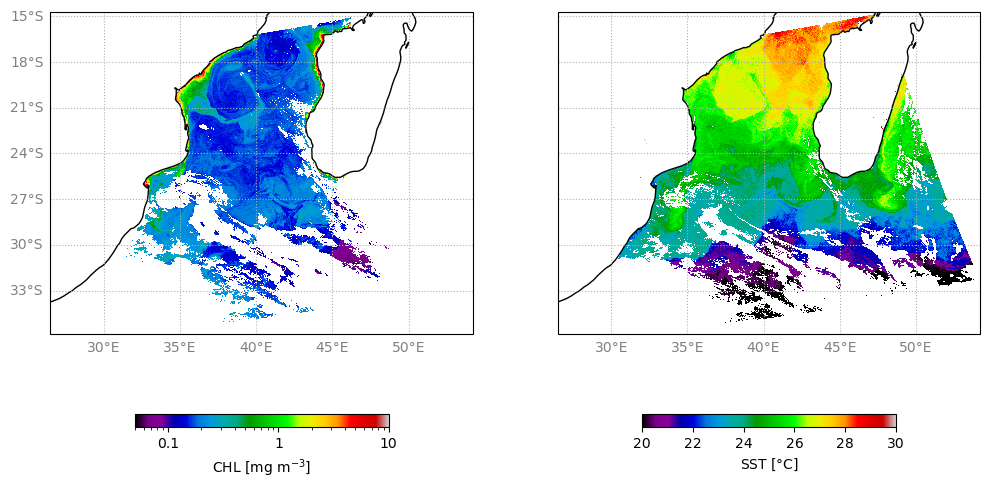

In [ ]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(12, 7), sharex=True, sharey=True,
														subplot_kw={'projection':ccrs.PlateCarree()})

cm_lon, cm_lat, cm_chl = get_data(files_cm_chl[0])
_, _, cm_sst = get_data(files_cm_sst[0], key='sst')

visualizar_cartopy(cm_lon, cm_lat, cm_chl, fig, ax, key='chlor_a', left_labels=True)
visualizar_cartopy(cm_lon, cm_lat, cm_sst, fig, bx, key='sst', left_labels=False)

- (2) Benguela Upwelling

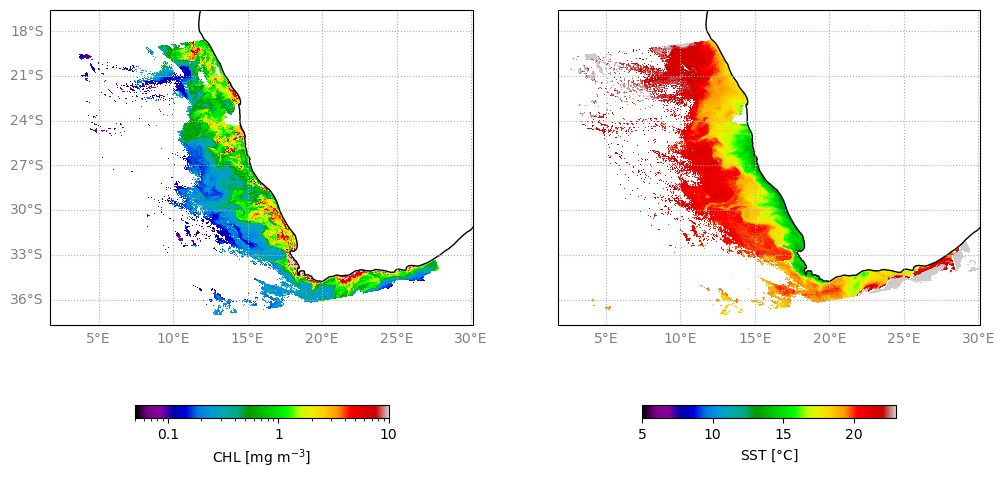

In [9]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(12, 7), sharex=True, sharey=True,
														subplot_kw={'projection':ccrs.PlateCarree()})

bu_lon, bu_lat, bu_chl = get_data(files_bu_chl[0])
_, _, bu_sst = get_data(files_bu_sst[0], key='sst')

visualizar_cartopy(bu_lon, bu_lat, bu_chl, fig, ax, key='chlor_a', left_labels=True)
visualizar_cartopy(bu_lon, bu_lat, bu_sst, fig, bx, key='sst', left_labels=False, vmin=5, vmax=23)

### Análise quantitativa: Relação de dispersão entre Clorofila e Temperatura


In [78]:
def get_subset(data, lon, lat, bbox):
	x0, y0, x1, y1 = bbox
	mask = ((lon >= x0) & (lon <= x1) & (lat >= y0) & (lat <= y1)).values
	if isinstance(data, np.ndarray):
		data[mask] = np.nan
	else:
		data = data.where(mask)
	return data

In [86]:
def visualizar_dispersao(x, y, ax, xlabel="SST [°C]", ylabel="CHL [mg m$^{-3}$]", yscale='lin'):
	if not isinstance(x, np.ndarray):
		x = x.values
	if not isinstance(y, np.ndarray):
		y = y.values
	x, y = x.ravel(), y.ravel()
	ax.scatter(x, y, s=1, alpha=0.3, color='k')
	if xlabel: ax.set_xlabel(xlabel)
	if ylabel: ax.set_ylabel(ylabel)
	if yscale: ax.set_yscale(yscale)
	ax.grid()
	
	y = np.log10(y) if yscale == 'log' else y
	idx = np.isnan(y) | np.isnan(x)
	res = stats.pearsonr(x[~idx], y[~idx])
	return res.statistic

Text(0.5, 0.98, 'Relação entre temperatura e clorofila')

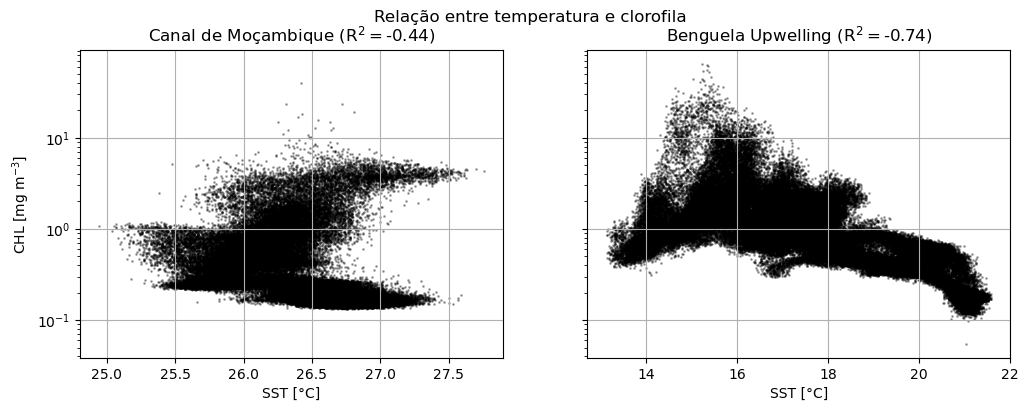

In [ ]:
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

chl_cm_subset = get_subset(cm_chl, cm_lon, cm_lat, (35, -21, 40, -18))
chl_bu_subset = get_subset(bu_chl, bu_lon, bu_lat, (10, -27, 15, -24))
cm_r = visualizar_dispersao(cm_sst, chl_cm_subset, ax, yscale='log')
bu_r = visualizar_dispersao(bu_sst, chl_bu_subset, bx, yscale='log', ylabel=None)

ax.set_title(f'Canal de Moçambique (R$^{2}=${cm_r:.2f})')
bx.set_title(f'Benguela Upwelling (R$^{2}=${bu_r:.2f})')
fig.suptitle("Relação entre temperatura e clorofila")

## Exercícios de Consolidação

As células a seguir mostram como baixar os dados de nível do mar (SLA) tanto para o Canal de Moçambique quanto para a região de Benguela.
Em seguida, é feita a visualização espacial (relação entre clorofila e SST) para o Canal de Moçambique.

1. Baixe dados de Nível 2 (clorofila e temperatura da superfície do mar) para datas e região de sua escolha e realize uma análise visual e quantitativa semelhante à apresentada no exemplo.
	- Dica: escolha uma área costeira ou oceânica com forte variabilidade sazonal, como o Canal de Moçambique ou a região de Benguela.
2. Repita a visualização para a região de Benguela e compare os resultados obtidos entre as duas áreas.
	- Quais diferenças espaciais e temporais observa entre as regiões?
	- Como essas diferenças se refletem na relação entre clorofila e temperatura?
3. Discuta as possíveis causas oceanográficas das diferenças observadas.

Nota:
A análise de dispersão para o nível do mar (SLA) é consideravelmente mais complexa e requer técnicas adicionais de interpolação e reamostragem. Como tal, será abordada em aulas mais avançadas.

<div class="alert alert-warning" style="border-radius:5px" role="alert">
Exercício de avaliação por submeter até as 23:59 do quinto (5) dia da semana.
</div>

In [25]:
if not Path.home().joinpath('.copernicusmarine/.copernicusmarine-credentials').is_file():
	auth = copernicusmarine.login()
dataset_id = "c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D"
files = []

for bbox, t in (((30, -30, 60, -10), "2023-06-15"), ((5, -40, 20, -20), '2021-05-01')):
	output_path = Path("L3/CM") if len(files) == 0 else Path("L3/BU")
	files.append(output_path.joinpath(f"{dataset_id}.nc"))
	output_path.mkdir(exist_ok=True, parents=True)

	copernicusmarine.subset(
		dataset_id=dataset_id,
		variables=["sla", 'ugos', 'vgos'],
		minimum_longitude=bbox[0],
		maximum_longitude=bbox[2],
		minimum_latitude=bbox[1],
		maximum_latitude=bbox[3],
		start_datetime=f"{t}T00:00:00",
		end_datetime=f"{t}T23:59:59",
		output_filename=f"{dataset_id}.nc",
		output_directory=output_path,
		skip_existing=True
	)

INFO - 2025-10-27T09:23:30Z - Selected dataset version: "202411"
INFO - 2025-10-27T09:23:30Z - Selected dataset part: "default"
INFO - 2025-10-27T09:23:36Z - Starting download. Please wait...
INFO - 2025-10-27T09:23:40Z - Successfully downloaded to L3\CM\c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D.nc
INFO - 2025-10-27T09:23:44Z - Selected dataset version: "202411"
INFO - 2025-10-27T09:23:44Z - Selected dataset part: "default"
INFO - 2025-10-27T09:23:48Z - Starting download. Please wait...
INFO - 2025-10-27T09:23:51Z - Successfully downloaded to L3\BU\c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D.nc


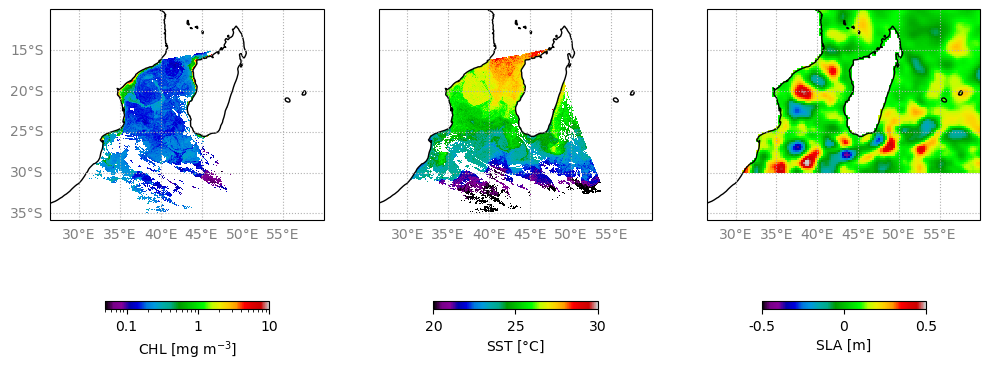

In [ ]:
fig, (ax, bx, cx) = plt.subplots(ncols=3, figsize=(12, 7), sharex=True, sharey=True,
                                 subplot_kw={'projection':ccrs.PlateCarree()})

cm_lon, cm_lat, cm_chl = get_data(files_cm_chl[0])
_, _, cm_sst = get_data(files_cm_sst[0], key='sst')
cm_slon, cm_slat, cm_sla = get_data(files[0], key='sla', level2=False)

visualizar_cartopy(cm_lon, cm_lat, cm_chl, fig, ax, key='chlor_a', left_labels=True)
visualizar_cartopy(cm_lon, cm_lat, cm_sst, fig, bx, key='sst', left_labels=False)
visualizar_cartopy(cm_slon, cm_slat, cm_sla, fig, cx, key='sla', left_labels=False, vmin=-.5, vmax=.5)